**Load Dataset**

In [53]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

In [40]:
# Install kaggle library
!pip install kaggle

# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"smmmmmmmm","key":"7b133f9532960b035175029dd9cafb37"}'}

In [54]:
# Move kaggle.json to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d sudalairajkumar/cryptocurrencypricehistory
!unzip cryptocurrencypricehistory.zip

Dataset URL: https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory
License(s): CC0-1.0
cryptocurrencypricehistory.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cryptocurrencypricehistory.zip
replace coin_Aave.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coin_BinanceCoin.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coin_Bitcoin.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace coin_Cardano.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [55]:
data = pd.read_csv("coin_Cardano.csv")

# Basic information about the dataset
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        1374 non-null   int64  
 1   Name       1374 non-null   object 
 2   Symbol     1374 non-null   object 
 3   Date       1374 non-null   object 
 4   High       1374 non-null   float64
 5   Low        1374 non-null   float64
 6   Open       1374 non-null   float64
 7   Close      1374 non-null   float64
 8   Volume     1374 non-null   float64
 9   Marketcap  1374 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 107.5+ KB


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


**Exploratory Data Analysis**


---


Daily Closing Price Over Time

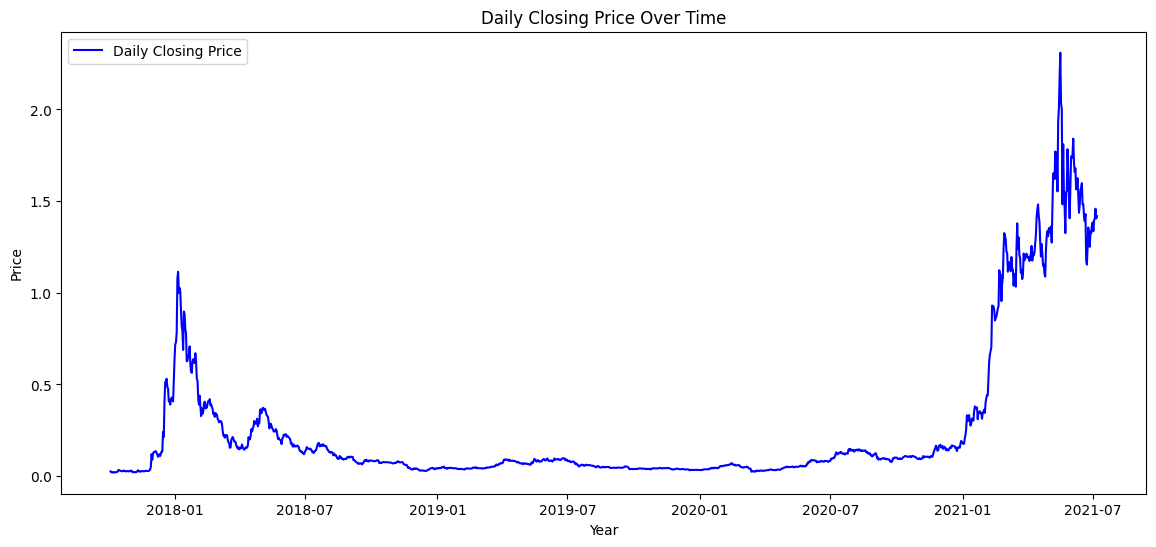

In [56]:
# Convert 'Date' to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], color='blue', label='Daily Closing Price')
plt.title('Daily Closing Price Over Time')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


Distribution of Daily Closing Prices

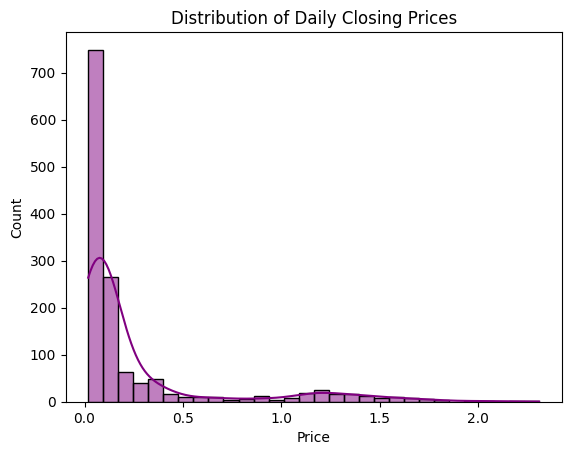

In [57]:
sns.histplot(data['Close'], kde=True, color='purple', bins=30)
plt.title('Distribution of Daily Closing Prices')
plt.xlabel('Price')
plt.show()


Seasonal Decomposition

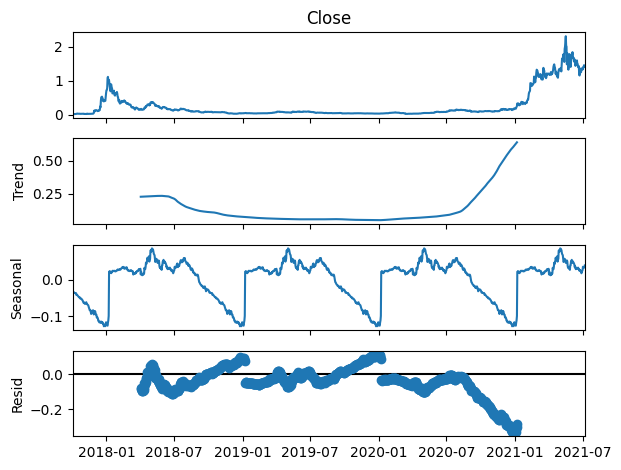

In [58]:
# Decompose the time series
decomposition = seasonal_decompose(data['Close'], model='additive', period=365)
decomposition.plot()
plt.show()


Rolling Mean and Standard Deviation

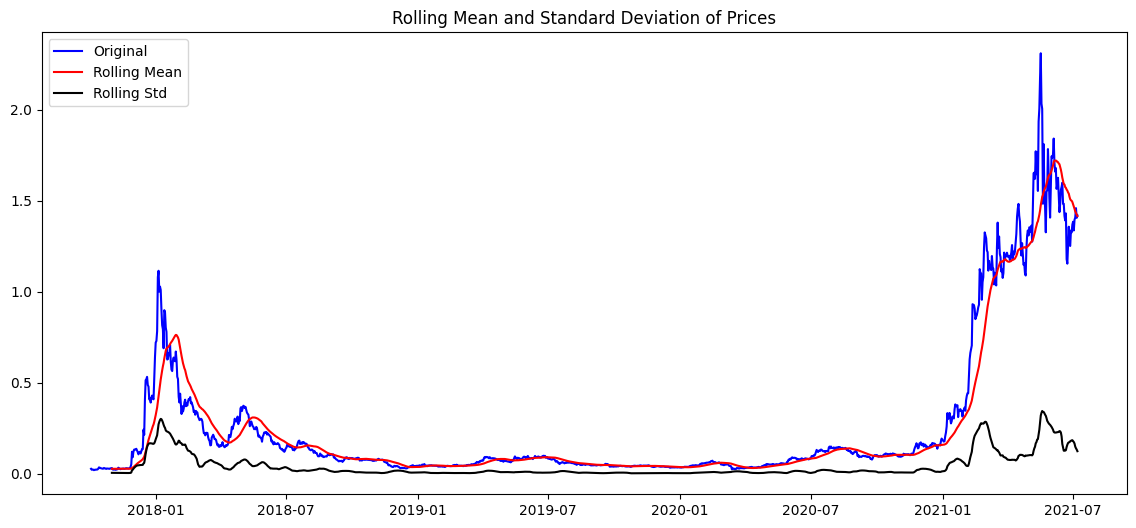

In [59]:
rolling_mean = data['Close'].rolling(window=30).mean()
rolling_std = data['Close'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Original', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.title('Rolling Mean and Standard Deviation of Prices')
plt.show()


Correlation Between Variables

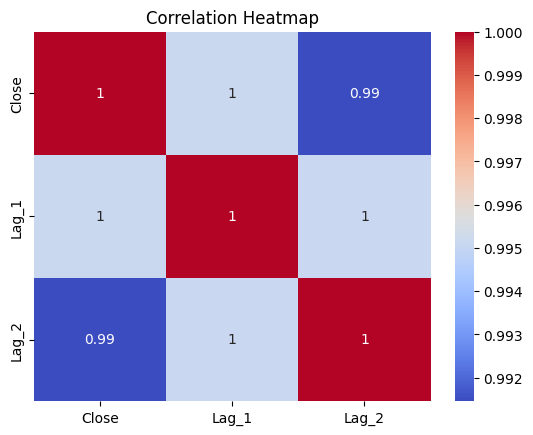

In [60]:
# Add lag features
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# Heatmap of correlations
correlation = data[['Close', 'Lag_1', 'Lag_2']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**Machine Learning Models**


---

Data Preprocessing

In [61]:
# Prepare lag features for ML
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)
data['Lag_3'] = data['Close'].shift(3)
data.dropna(inplace=True)

# Define features and target
X = data[['Lag_1', 'Lag_2', 'Lag_3']]
y = data['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model Training


Linear Regression

In [62]:
# Train and evaluate Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
predictions_lr = lr.predict(X_test_scaled)

print("Linear Regression Performance:")
print(f"MAE: {mean_absolute_error(y_test, predictions_lr):.2f}")
print(f"MSE: {mean_squared_error(y_test, predictions_lr):.2f}")
print(f"R2 Score: {r2_score(y_test, predictions_lr):.2f}")


Linear Regression Performance:
MAE: 0.02
MSE: 0.00
R2 Score: 0.99


Random Forest Regressor with Hyperparameter Tuning

In [63]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
rf.fit(X_train_scaled, y_train)

print(f"Best Parameters: {rf.best_params_}")
best_rf = rf.best_estimator_

# Evaluate Random Forest
predictions_rf = best_rf.predict(X_test_scaled)
print("Random Forest Performance:")
print(f"MAE: {mean_absolute_error(y_test, predictions_rf):.2f}")
print(f"MSE: {mean_squared_error(y_test, predictions_rf):.2f}")
print(f"R2 Score: {r2_score(y_test, predictions_rf):.2f}")


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest Performance:
MAE: 0.02
MSE: 0.00
R2 Score: 0.99


**Forecasting**

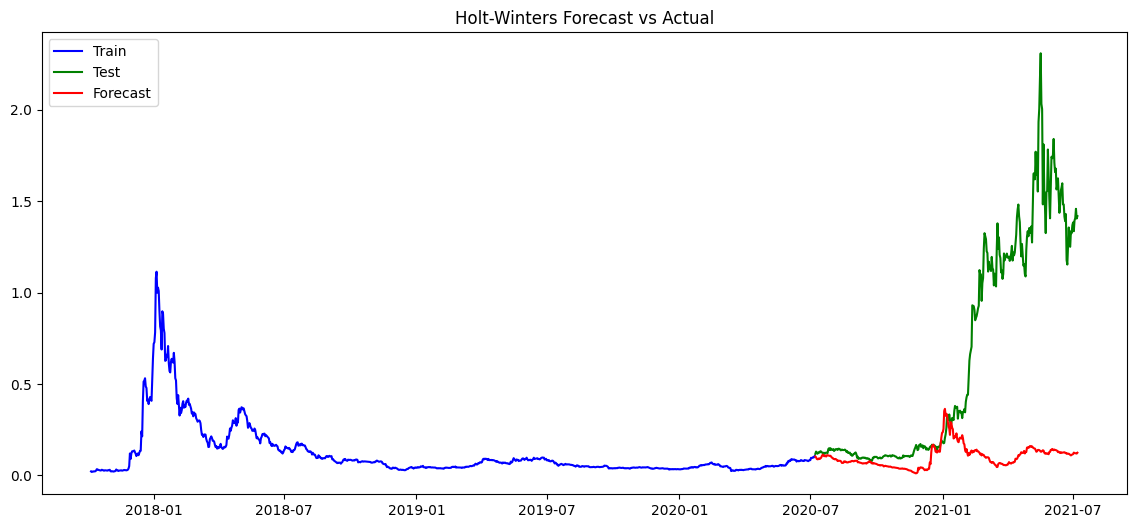

In [64]:
# Train-Test Split for Forecasting
train = data['Close'][:-365]
test = data['Close'][-365:]

# Apply Holt-Winters
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
fit = model.fit()
forecast = fit.forecast(len(test))

# Plot observed and forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test', color='green')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('Holt-Winters Forecast vs Actual')
plt.show()


Forecasting Model Evaluations

In [65]:
mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print("Forecast Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")


Forecast Evaluation:
MAE: 0.54
MSE: 0.65
R2 Score: -0.75
